`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   

# Лабораторная работа №6: Машины опорных векторов. 

#### Работу выполнила студентка ПМИ3-1 Марахова Екатерина, вариант №13.

В практических примерах ниже показано:    
* как классифицировать данные с помощью модели SVM
* как использовать конвейеры для подгонки модели и применения её к новым даннымё

Точность всех моделей оценивается методом перекрёстной проверки по 5 блокам.  

*Модели*: множественная линейная регрессия 

*Данные*: `default_of_credit_card_clients` (источник: [репозиторий](https://github.com/aksyuk/MTML/blob/main/Labs/data/default_of_credit_card_clients.csv))

*Объясняющие переменные*: все, кроме Y

*Метод, основанный на деревьях решений*: бэггинг

# Указания к выполнению


## Загружаем пакеты

In [492]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка символьных показателей
from sklearn.preprocessing import LabelEncoder
# загрузка файлов по URL
import urllib
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency, t
#  для таймера
import time

# загрузка пакетов: модели ------------------------------------------------- 
# SVM
from sklearn.svm import SVC
# логистическая рагрессия
from sklearn.linear_model import LogisticRegression 
# стандартизация
from sklearn.preprocessing import StandardScaler
# метод главных компонент
from sklearn.decomposition import PCA
# конвейеры
from sklearn.pipeline import make_pipeline
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split 
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# сводка по точности классификации
from sklearn.metrics import classification_report

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree


# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier

# для теста хи-квадрат
import scipy

# для метода ближайших соседей
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [493]:
# константы
#  ядро для генератора случайных чисел
my_seed = 13
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

# Загружаем данные

Данные по кредитам 30000 клиентов банков Тайваня (статистика 2005 года). 

`Задача`: спрогнозировать дефолт платежа в следущем месяце по статистике за 6 предыдущих месяцев и по общим сведениям о клиенте. 

`Источник данных`: статья Yeh, I. C., & Lien, C. H. The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480. (Набор данных был загружен из репозитория [UCI](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)).

### Список столбцов файла: 
* `LIMIT_BAL` – размер выданного кредита (новых тайваньских долларов);  
  
  
* `SEX` – пол:  
1 = мужской,   
2 = женский;   

  
* `EDUCATION` – образование:  
1 = аспирантура,   
2 = университет,   
3 = старшая школа,   
4 = другое;  
  
  
* `MARRIAGE` – семейное положение:   
1 = женат/замужем,   
2 = одинок,   
3 = другое;  
  
  
* `AGE` – возраст, лет;  
  
  
* `PAY_0, PAY_2,PAY_3, PAY_4, PAY_5, PAY_6` – статус последних ежемесячных платежей, с сентября (`PAY_0`) по апрель (`PAY_6`) 2005 года:   
\-1 = платёж внесён вовремя,   
1 = платёж внесён с опозданием на 1 месяц;   
2 = с опозданием на 2 месяца,   
и т.д.,   
9 = с опозданием на 9 месяцев и более;  
  
  
* `BILL_AMT1, ..., BILL_AMT6` – размер последних ежемесячных платежей (новых тайваньских долларов), с сентября (`BILL_AMT1`) по апрель (`BILL_AMT6`) 2005 года;  
  
  
* `PAY_AMT1, ..., PAY_AMT6` – размер ежемесячных платежей в предыдущем месяце (новых тайваньских долларов), с сентября (`PAY_AMT1` за август) по апрель (`PAY_AMT6` за март) 2005 года;  
  
  
* `Y` – целевая переменная: дефолт в следующем месяце (1 – да, 0 – нет).


Загружаем данные во фрейм и выясняем их размерность. 

In [494]:
# загружаем таблицу и превращаем её во фрейм
fileURL = 'https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/default_of_credit_card_clients.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

# смотрим на данные
DF_raw.iloc[:, :12].head(5)

Число строк и столбцов в наборе данных:
 (30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913
1,120000,2,2,2,26,-1,2,0,0,0,2,2682
2,90000,2,2,2,34,0,0,0,0,0,0,29239
3,50000,2,2,1,37,0,0,0,0,0,0,46990
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617


In [495]:
DF_raw.iloc[:, 12:].head(5)

,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
0,3102,689,0,0,0,0,689,0,0,0,0,1
1,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [496]:
# типы столбцов
DF_raw.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
dtype: object

Функция построения дерева классификации `DecisionTreeClassifier()` требует числовых порядковых значений переменных, поэтому наши данные полностью подходят.

In [497]:
DF_raw.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Y            0
dtype: int64

# Предварительный анализ данных. Описательные статистики.

##  Подсчет частот категориальных значений.

In [498]:
DF_raw['Y'].unique()

array([1, 0])

In [499]:
np.around(DF_raw.Y.value_counts() / len(DF_raw.index), 3)

0    0.779
1    0.221
Name: Y, dtype: float64

In [500]:
DF_raw['SEX'].unique()

array([2, 1])

In [501]:
np.around(DF_raw.SEX.value_counts() / len(DF_raw.index), 3)

2    0.604
1    0.396
Name: SEX, dtype: float64

In [502]:
DF_raw['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [503]:
np.around(DF_raw.EDUCATION.value_counts() / len(DF_raw.index), 3)

2    0.468
1    0.353
3    0.164
5    0.009
4    0.004
6    0.002
0    0.000
Name: EDUCATION, dtype: float64

In [504]:
DF_raw['MARRIAGE'].unique()

array([1, 2, 3, 0])

In [505]:
np.around(DF_raw.MARRIAGE.value_counts() / len(DF_raw.index), 3)

2    0.532
1    0.455
3    0.011
0    0.002
Name: MARRIAGE, dtype: float64

## ХИ-КВАДРАТ
### Y и SEX


In [506]:
df_Y_SEX = pd.crosstab(DF_raw['Y'], DF_raw['SEX'])
df_Y_SEX

SEX,1,2
Y,,
0,9015,14349
1,2873,3763


In [507]:
list_Y_SEX = [[df_Y_SEX[1][0], df_Y_SEX[2][0]], 
              [df_Y_SEX[1][1], df_Y_SEX[2][1]]]
list_Y_SEX

[[9015, 14349], [2873, 3763]]

In [508]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(list_Y_SEX)
output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"
print(output.format(chi2, df, prob))
print(expected)

test Statistics: 47.70879689062111
degrees of freedom: 1
p-value: 4.944678999412044e-12

[[ 9258.3744 14105.6256]
 [ 2629.6256  4006.3744]]


### Y и EDUCATION

In [509]:
df_Y_EDUCATION = pd.crosstab(DF_raw['Y'], DF_raw['EDUCATION'])
df_Y_EDUCATION

EDUCATION,0,1,2,3,4,5,6
Y,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


In [510]:
list_Y_EDUCATION = [[df_Y_EDUCATION[0][0], df_Y_EDUCATION[1][0], df_Y_EDUCATION[2][0], 
                     df_Y_EDUCATION[3][0], df_Y_EDUCATION[4][0], 
                     df_Y_EDUCATION[5][0], df_Y_EDUCATION[6][0]], 
                    
                    [df_Y_EDUCATION[0][1],df_Y_EDUCATION[1][1], df_Y_EDUCATION[2][1], 
                     df_Y_EDUCATION[3][1], df_Y_EDUCATION[4][1], 
                     df_Y_EDUCATION[5][1], df_Y_EDUCATION[6][1]]]
list_Y_EDUCATION

[[14, 8549, 10700, 3680, 116, 262, 43], [0, 2036, 3330, 1237, 7, 18, 8]]

In [511]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(list_Y_EDUCATION)
output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"
print(output.format(chi2, df, prob))
print(expected)

test Statistics: 163.21655786997073
degrees of freedom: 6
p-value: 1.2332626245415605e-32

[[1.0903200e+01 8.2435980e+03 1.0926564e+04 3.8293596e+03 9.5792400e+01
  2.1806400e+02 3.9718800e+01]
 [3.0968000e+00 2.3414020e+03 3.1034360e+03 1.0876404e+03 2.7207600e+01
  6.1936000e+01 1.1281200e+01]]


### Y и MARRIAGE

In [512]:
df_Y_MARRIAGE = pd.crosstab(DF_raw['Y'], DF_raw['MARRIAGE'])
df_Y_MARRIAGE

MARRIAGE,0,1,2,3
Y,,,,
0,49,10453,12623,239
1,5,3206,3341,84


In [513]:
list_Y_MARRIAGE = [[df_Y_MARRIAGE[0][0], df_Y_MARRIAGE[1][0], df_Y_MARRIAGE[2][0], 
                     df_Y_EDUCATION[3][0]], 
                    
                    [df_Y_MARRIAGE[0][1], df_Y_MARRIAGE[1][1], df_Y_MARRIAGE[2][1], 
                     df_Y_MARRIAGE[3][1]]]

In [514]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(list_Y_MARRIAGE)
output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"
print(output.format(chi2, df, prob))
print(expected)

test Statistics: 862.6546357557238
degrees of freedom: 3
p-value: 1.1150313044206167e-186

[[4.32842917e+01 1.09485211e+04 1.27961191e+04 3.01707545e+03]
 [1.07157083e+01 2.71047887e+03 3.16788086e+03 7.46924554e+02]]


## Описательные статистики для непрерывных переменных набора.

In [515]:
DF_raw.iloc[:, :1].describe()

,LIMIT_BAL
count,30000.000000
mean,167484.322667
std,129747.661567
min,10000.000000
25%,50000.000000
50%,140000.000000
75%,240000.000000
max,1000000.000000


In [516]:
DF_raw.iloc[:, 4:14].describe()

,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04
mean,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04
std,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04
min,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05
25%,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03
50%,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04
75%,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04
max,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06


In [517]:
DF_raw.iloc[:, 14:].describe()

,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


**Выводы по описательным статистикам**: некоторые минимумы значений принимают отрицательные значения, а стандартные отклонения имеют очень большие значения и достаточно большой разброс, что говорит о неоднородности данных. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений.   

## Создание фиктивных переменных.

In [518]:
DF_copy = DF_raw.copy()
categorical_cols = ['SEX','EDUCATION','MARRIAGE']
DF_copy = pd.get_dummies(DF_copy, columns = categorical_cols)

In [519]:
DF_copy.iloc[:, :17].head(5)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0
1,120000,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000
2,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000
3,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200
4,50000,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000


In [520]:
DF_copy.iloc[:, 17:].head(5)

,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0
1,1000,0,2000,1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,1000,1000,5000,0,0,1,0,0,1,0,0,0,0,0,0,1,0
3,1100,1069,1000,0,0,1,0,0,1,0,0,0,0,0,1,0,0
4,9000,689,679,0,1,0,0,0,1,0,0,0,0,0,1,0,0


In [521]:
#SEX_1 - мужской пол

#удаляем лишние фиктивные
DF_copy = DF_copy.drop('SEX_2', axis=1)
#в образовании появляются новые переменные 0, 5 и 6 их тоже удаляем
DF_copy = DF_copy.drop('EDUCATION_0', axis=1)
DF_copy = DF_copy.drop('EDUCATION_4', axis=1)
DF_copy = DF_copy.drop('EDUCATION_5', axis=1)
DF_copy = DF_copy.drop('EDUCATION_6', axis=1)
#в семейном положении появляется новая переменная 0 ее тоже удаляем
DF_copy = DF_copy.drop('MARRIAGE_0', axis=1)
DF_copy = DF_copy.drop('MARRIAGE_3', axis=1)


In [522]:
DF_copy.iloc[:, 8:].head(5)

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,SEX_1,EDUCATION_1,EDUCATION_2,EDUCATION_3,MARRIAGE_1,MARRIAGE_2
0,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,0,1,0,1,0
1,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,0,1,0,0,1
2,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,0,1,0,0,1
3,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,0,1,0,1,0
4,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,1,0,1,0


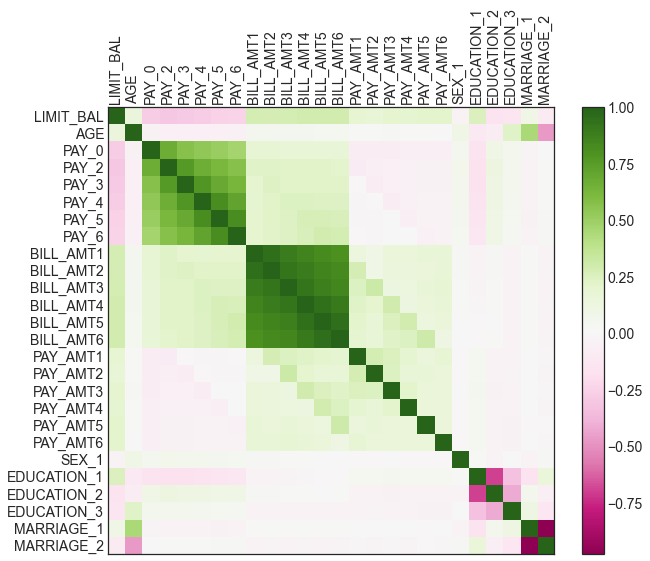

In [523]:
# рассчитываем корреляционную матрицу
corr_mat = DF_copy.drop('Y', axis=1).corr()
col_names = DF_copy.drop('Y', axis=1).columns

# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')

# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

# доп удаление переменных

In [524]:
# для увеличения точности модели удалим только тчо созданные фиктивные переменные (:
#DF_copy = DF_copy.drop(['EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'SEX_1', 'MARRIAGE_1', 'MARRIAGE_2'], axis=1)

In [434]:
# и еще чуть-чуть 
# оставим значения декабрь-январь-февраль 3-4-5
#DF_copy = DF_copy.drop(['PAY_0', 'PAY_2', 'PAY_6'], axis=1)


In [525]:
DF_copy = DF_copy.drop(['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'], axis=1)
DF_copy = DF_copy.drop(['SEX_1'], axis=1)
DF_copy = DF_copy.drop(['AGE'], axis=1)

In [526]:
#DF_copy = DF_copy.drop(['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT6'], axis=1)

# --------------------------------

In [527]:
DF_copy

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,Y,EDUCATION_1,EDUCATION_2,EDUCATION_3,MARRIAGE_1,MARRIAGE_2
0,20000,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,1,0,1,0,1,0
1,120000,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,1,0,1,0,0,1
2,90000,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,0,0,1,0,0,1
3,50000,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,0,0,1,0,1,0
4,50000,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,0,0,0,1,1,0
29996,150000,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,0,0,0,1,0,1
29997,30000,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,1,0,1,0,0,1
29998,80000,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,1,0,0,1,1,0


#### Переместим зависимую переменную в начало фрейма для удобства.

In [529]:
DF_copy = DF_copy[ ['Y'] + [ col for col in DF_copy.columns if col != 'Y' ] ]
DF_copy.iloc[:, :].head(5)

,Y,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_1,EDUCATION_2,EDUCATION_3,MARRIAGE_1,MARRIAGE_2
0,1,20000,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,1,0,1,0
1,1,120000,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1,0,0,1
2,0,90000,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,0,1,0,0,1
3,0,50000,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,0,1,0,1,0
4,0,50000,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,0,1,0,1,0


In [530]:
DF_copy.iloc[:, 10:].head(5)

,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_1,EDUCATION_2,EDUCATION_3,MARRIAGE_1,MARRIAGE_2
0,689,0,0,0,0,1,0,1,0
1,2682,3272,3455,3261,0,1,0,0,1
2,13559,14331,14948,15549,0,1,0,0,1
3,49291,28314,28959,29547,0,1,0,1,0
4,35835,20940,19146,19131,0,1,0,1,0


### Отложим 15% наблюдений для прогноза.

In [531]:
# наблюдения для моделирования
DF = DF_copy.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_copy.drop(DF.index)
DF_predict = DF_copy.drop(DF.Y)

# Преобразование исходных данных и построение моделей
## Стандартизация и переход к главным компонентам

В качестве альтернативных моделей рассмотрим SVM с различными вариантами ядер и логистическую регрессию. Причём предварительно преобразуем пространство исходных показателей с помощью метода главных компонент.

In [532]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, 1:].values)

# оцениваем объяснённую главными компонентами дисперсию
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)

# считаем доли объяснённой дисперсии
frac_var_expl = pca.explained_variance_ratio_
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
    np.around(frac_var_expl, 3),
    '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.354 0.211 0.117 0.088 0.067 0.04  0.033 0.023 0.016 0.015 0.011 0.008
 0.006 0.004 0.002 0.002 0.001 0.001] 
Общая сумма долей: 1.0


Таким образом, первые две главные компоненты объясняют 41.7% разброса 30 объясняющих переменных.
Теперь объединим функции-преобразователи и оценщики в конвейер с помощью `Pipeline` и оценим точность логистической регрессии с помощью перекрёстной проверки.

## Модель логистической регрессии с перекрёстной проверкой

In [533]:
DF.iloc[:, 0].head(5)

3195     0
15960    0
17713    0
17897    0
23049    1
Name: Y, dtype: int64

In [558]:
# данные для обучения моделей
X_train = DF.iloc[:, 1:] 
y_train = DF.iloc[:, 0]

# объединяем в конвейер шкалирование, ГК с 5 компонентами и логит
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components = 7), #5
                        LogisticRegression(random_state = my_seed, 
                                           solver = 'lbfgs'))

# будем сохранять точность моделей в один массив
score = list()
score_models = list()

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator = pipe_lr, X = X_train, y = y_train, 
                     cv = 5, scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3)) 
score_models.append('sc_pca_logit')
print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[0], ':', score[0])

Acc с перекрёстной проверкой 
для модели sc_pca_logit : 0.805


In [535]:
print('Число строк и столбцов в наборе данных:\n', X_train.shape)

Число строк и столбцов в наборе данных:
 (25500, 18)


## SVM с перекрёстной проверкой

Построим несколько вариантов модели SVM с различными ядерными функциями.

In [536]:
pipe_svc = make_pipeline(StandardScaler(), 
                         SVC(random_state = my_seed))

# настроим параметры SVM с помощью сеточного поиска
param_range = [0.0001, 0.001] #[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__degree' : [2, 3],
               'svc__kernel': ['poly']}]

# разбиения для перекрёстной проверки
kfold = KFold(n_splits = 5, random_state = my_seed, shuffle = True)

gs = GridSearchCV(estimator = pipe_svc, param_grid = param_grid, 
                  scoring = 'accuracy', refit = True, cv = kfold, 
                  n_jobs = -1)

# таймер
tic = time.perf_counter()

# запускаем сеточный поиск
gs = gs.fit(X_train, y_train)

# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

# записываем точность
score.append(np.around(gs.best_score_, 3)) 
score_models.append('svm')

Сеточный поиск занял 524.46 секунд


In [539]:
# точность лучшей модели
np.around(gs.best_score_, 3)

0.782

In [540]:
# параметры лучшей модели
# * ядерная функция 
gs.best_estimator_.get_params()['svc__kernel']

'linear'

In [541]:
# * параметр регуляризации
gs.best_estimator_.get_params()['svc__C']

0.001

In [542]:
# * коэффициент ядерной функции (для ядер 'rbf', 'poly' и 'sigmoid')
gs.best_estimator_.get_params()['svc__gamma']

'scale'

In [543]:
# * степень полинома (для ядра 'poly')
gs.best_estimator_.get_params()['svc__degree']

3

## Метод kNN

In [544]:
k_range = list(range(1,64))
weight_options = ["uniform", "distance"]

pipe_knn = Pipeline(steps=[('standard', StandardScaler()), 
                           ('PCA', PCA(n_components = 5)), 
                           ('knn', KNeighborsClassifier())
                          ])
param_grid = {'knn__n_neighbors': list(range(1,64))}

knn = KNeighborsClassifier()
kfold = KFold(n_splits = 5, random_state = my_seed, shuffle = True)
grid = GridSearchCV(pipe_knn, param_grid, cv = kfold, scoring = 'accuracy')

tic = time.perf_counter()
grid.fit(X_train, y_train)
toc = time.perf_counter()

print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 101.44 секунд


In [545]:
score.append(np.around(grid.best_score_,3))
score_models.append('sc_pca_knn')

print('Acc с перекрёстной проверкой','\nдля модели',score_models[1],':',score[1])

Acc с перекрёстной проверкой 
для модели svm : 0.782


## Прогноз на отложенные наблюдения по лучшей модели

In [546]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,sc_pca_logit,0.805
1,svm,0.782
2,sc_pca_knn,0.805


In [224]:
# прогноз с помощью лучшей модели ансамбля с SVC
y_hat = gs.best_estimator_.predict(X = DF_predict.iloc[:, 1:])
# точность
# характеристики точности 
print(classification_report(DF_predict.iloc[:, 0], y_hat))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     23364
           1       0.63      0.01      0.03      6634

    accuracy                           0.78     29998
   macro avg       0.71      0.51      0.45     29998
weighted avg       0.75      0.78      0.69     29998



# Источники 

1. Джеймс Г., Уиттон Д., Хасти Т., Тибширани Р. Введение в статистическое обучение с примерами на языке R. Пер. с англ. С.Э. Мастицкого – М.: ДМК Пресс, 2016 – 450 с.  
1. *Рашка С.* Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.  
1. *Tong Wang*, *Cynthia Rudin*, *Finale Doshi-Velez*, *Yimin Liu*, *Erica Klampfl*, *Perry MacNeille* A Bayesian Framework for Learning Rule Sets for Interpretable Classification / Journal of Machine Learning Research 18 (2017) 1-37. URL: <https://jmlr.org/papers/volume18/16-003/16-003.pdf>  
1. *George Pipis* How to Run the Chi-Square Test in Python / medium.com. URL: <https://medium.com/swlh/how-to-run-chi-square-test-in-python-4e9f5d10249d>   
1. *Bernd Klein* What are Decision Trees? / python-course.eu. URL: <https://www.python-course.eu/Decision_Trees.php>  
1. Pruning decision trees - tutorial / kaggle.com. URL: <https://www.kaggle.com/arunmohan003/pruning-decision-trees-tutorial>  
1. Post pruning decision trees with cost complexity pruning / scikit-learn.org. URL: <https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html>  
1. *Piotr Płoński* Visualize a Decision Tree in 4 Ways with Scikit-Learn and Python / mljar.com. URL: <https://mljar.com/blog/visualize-decision-tree/>  
1. Random Forest Feature Importance Plot / www.analyseup.com. URL: <https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html>  